# Fast training with MONAI features

This tutorial shows a regular PyTorch training program and a MONAI optimized training program, and compared the performance.  
Mainly includes:
1. AMP (Auto mixed precision).
2. CacheDataset for deterministic transforms.
3. Move data to GPU and cache, then execute random transforms on GPU.
4. multi-threads `ThreadDataLoader` is faster than PyTorch DataLoader in light-weight task.
5. Use MONAI `DiceCE` loss instead of regular `Dice` loss.
6. Analyzed training curve and tuned algorithm: Use `SGD` optimizer, different network parameters, etc.

With a V100 GPU and the target validation `mean dice = 0.94` of the `forground` channel only,  it's more than `100x` speedup compared with the Pytorch regular implementation when achieving the same metric. And every epoch is `20x` faster than regular training.

It's modified from the Spleen 3D segmentation tutorial notebook, the Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/acceleration/fast_training_tutorial.ipynb)(* please note that the free GPU resource in Colab may be not as powerful as the V100 test results in this notebook: it may not support AMP and the GPU computation of transforms may be not faster than the CPU computation.)

## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToDeviced,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [4]:
train_images = sorted(
    glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz"))
)
train_labels = sorted(
    glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz"))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [5]:
def transformations(fast=False):
    train_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # pre-compute foreground and background indexes
        # and cache them to accelerate training
        FgBgToIndicesd(
            keys="label",
            fg_postfix="_fg",
            bg_postfix="_bg",
            image_key="image",
        ),
        # change to execute transforms with Tensor data
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        train_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )
    train_transforms.append(
        # randomly crop out patch samples from big
        # image based on pos / neg ratio
        # the image centers of negative samples
        # must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            fg_indices_key="label_fg",
            bg_indices_key="label_bg",
        ),
    )

    val_transforms = [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
    if fast:
        # move the data to GPU and cache to avoid CPU -> GPU sync in every epoch
        val_transforms.append(
            ToDeviced(keys=["image", "label"], device="cuda:0")
        )

    return Compose(train_transforms), Compose(val_transforms)

## Define the training progress
For a typical PyTorch regular training procedure, use regular `Dataset`, `DataLoader`, `Adam` optimizer and `Dice` loss to train the model.

For MONAI fast training progress, we mainly introduce the following features:
1. `AMP` (auto mixed precision): AMP is an important feature released in PyTorch v1.6, NVIDIA CUDA 11 added strong support for AMP and significantly improved training speed.
2. `CacheDataset`: Dataset with the cache mechanism that can load data and cache deterministic transforms' result during training.
3. `ToDeviced` transform: to move data to GPU and cache with `CacheDataset`, then execute random transforms on GPU directly, avoid CPU -> GPU sync in every epoch. Please note that not all the MONAI transforms support GPU operation so far, still working in progress.
4. `ThreadDataLoader`: uses multi-threads instead of multi-processing, faster than `DataLoader` in light-weight task as we already cached the results of most computation.
5. `DiceCE` loss function: computes Dice loss and Cross Entropy Loss, returns the weighted sum of these two losses.
6. Analyzed the training curve and tuned algorithm: Use `SGD` optimizer, different network parameters, etc.

In [6]:
def train_process(fast=False):
    max_epochs = 600
    learning_rate = 2e-4
    val_interval = 5  # do validation for every epoch
    device = torch.device("cuda:0")

    train_trans, val_trans = transformations(fast=fast)
    # set CacheDataset, ThreadDataLoader and DiceCE loss for MONAI fast training
    if fast:
        # as `RandCropByPosNegLabeld` crops from the cached content and `deepcopy`
        # the crop area instead of modifying the cached value, we can set `copy_cache=False`
        # to avoid unnecessary deepcopy of cached content in `CacheDataset`
        train_ds = CacheDataset(
            data=train_files,
            transform=train_trans,
            cache_rate=1.0,
            num_workers=8,
            copy_cache=False,
        )
        val_ds = CacheDataset(
            data=val_files, transform=val_trans, cache_rate=1.0, num_workers=5, copy_cache=False
        )
        # disable multi-workers because `ThreadDataLoader` works with multi-threads
        train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=4, shuffle=True)
        val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)
        loss_function = DiceCELoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True,
            squared_pred=True,
            batch=True,
            smooth_nr=0.00001,
            smooth_dr=0.00001,
            lambda_dice=0.5,
            lambda_ce=0.5,
        )
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
            kernel_size=3,
            up_kernel_size=3,
            act=Act.PRELU,
            dropout=0.2,
            bias=True,
            dimensions=None,
        ).to(device)
    else:
        train_ds = Dataset(data=train_files, transform=train_trans)
        val_ds = Dataset(data=val_files, transform=val_trans)
        # num_worker=4 is the best parameter according to the test
        train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
        loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

    if fast:
        # SGD prefer to much bigger learning rate
        optimizer = SGD(
            model.parameters(),
            lr=learning_rate * 1000,
            momentum=0.9,
            weight_decay=0.00004,
        )
        scaler = torch.cuda.amp.GradScaler()
    else:
        optimizer = Adam(model.parameters(), learning_rate)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [[], [], []]
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()
    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            # set AMP for MONAI training
            if fast:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)
            print(
                f"{step}/{epoch_len}, train_loss: {loss.item():.4f}"
                f" step time: {(time.time() - step_start):.4f}"
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    # set AMP for MONAI validation
                    if fast:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(
                                val_inputs, roi_size, sw_batch_size, model
                            )
                    else:
                        val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model
                        )
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(
                        time.time() - total_start
                    )
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pt"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(
            f"time consuming of epoch {epoch + 1} is:"
            f" {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    total_time = time.time() - total_start
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {total_time:.4f}"
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        epoch_times,
        best_metrics_epochs_and_time,
        total_time,
    )

## Enable determinism and execute regular PyTorch training

In [ ]:
set_determinism(seed=0)
regular_start = time.time()
(
    epoch_num,
    epoch_loss_values,
    metric_values,
    epoch_times,
    best,
    train_time,
) = train_process(fast=False)
total_time = time.time() - regular_start
print(
    f"total time of {epoch_num} epochs with regular PyTorch training: {total_time:.4f}"
)

## Enable determinism and execute MONAI optimized training

In [ ]:
set_determinism(seed=0)
monai_start = time.time()
(
    epoch_num,
    m_epoch_loss_values,
    m_metric_values,
    m_epoch_times,
    m_best,
    m_train_time,
) = train_process(fast=True)
m_total_time = time.time() - monai_start
print(
    f"total time of {epoch_num} epochs with MONAI fast training: {m_train_time:.4f},"
    f" time of preparing cache: {(m_total_time - m_train_time):.4f}"
)

## Plot training loss and validation metrics

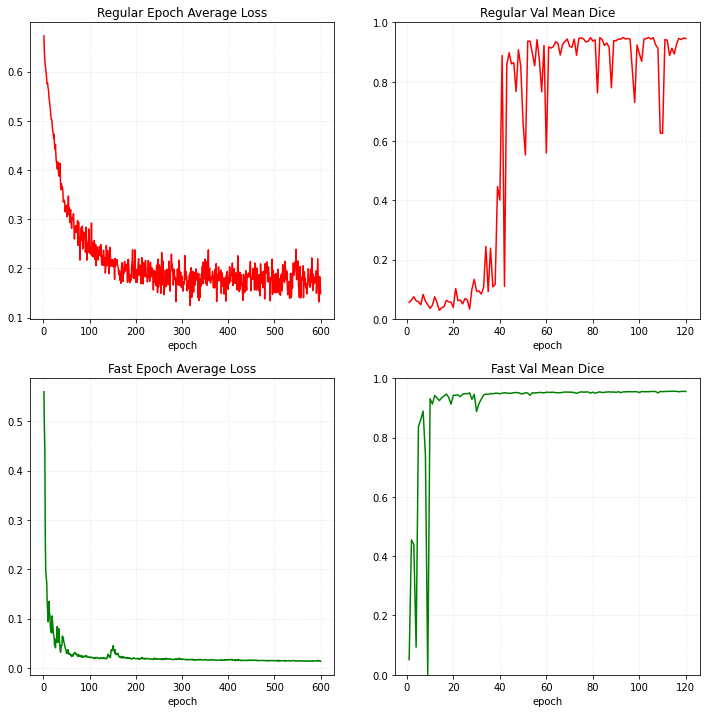

In [52]:
plt.figure("train", (12, 12))
plt.subplot(2, 2, 1)
plt.title("Regular Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 2)
plt.title("Regular Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(2, 2, 3)
plt.title("Fast Epoch Average Loss")
x = [i + 1 for i in range(len(m_epoch_loss_values))]
y = m_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")

plt.subplot(2, 2, 4)
plt.title("Fast Val Mean Dice")
x = [i + 1 for i in range(len(m_metric_values))]
y = m_metric_values
plt.xlabel("epoch")
plt.ylim(0, 1)
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")
plt.show()

## Plot total time and every epoch time

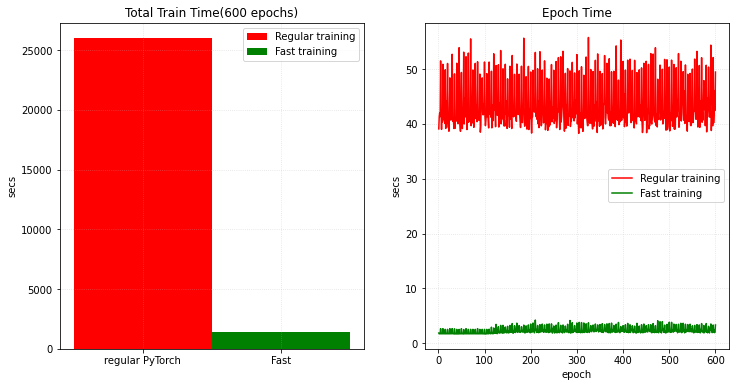

In [49]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Total Train Time(600 epochs)")
plt.bar(
    "regular PyTorch", total_time, 1, label="Regular training", color="red"
)
plt.bar("Fast", m_total_time, 1, label="Fast training", color="green")
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel("epoch")
plt.ylabel("secs")
plt.plot(x, epoch_times, label="Regular training", color="red")
plt.plot(x, m_epoch_times, label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Plot total time to achieve metrics

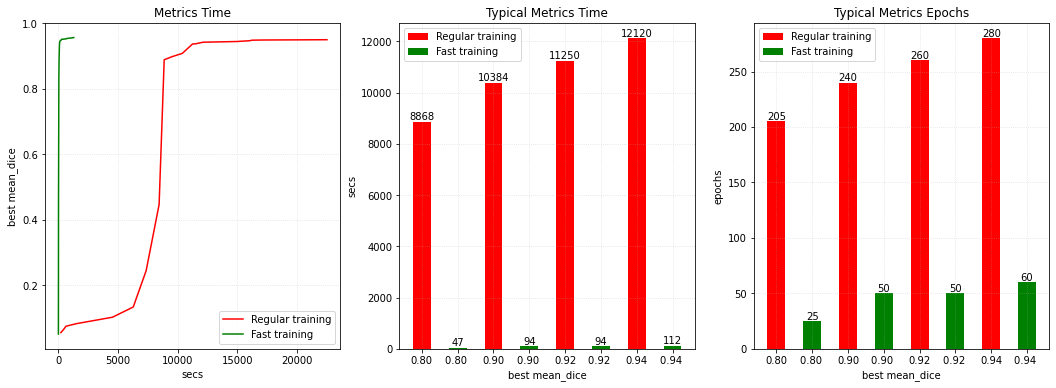

In [50]:
def get_best_metric_time(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if round(v, 4) >= threshold:
            return best_values[2][i]
    return -1


def get_best_metric_epochs(threshold, best_values):
    for i, v in enumerate(best_values[0]):
        if round(v, 4) >= threshold:
            return best_values[1][i]
    return -1


def get_label(index):
    if index == 0:
        return "Regular training"
    elif index == 1:
        return "Fast training"
    else:
        return None


plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Metrics Time")
plt.xlabel("secs")
plt.ylabel("best mean_dice")
plt.plot(best[2], best[0], label="Regular training", color="red")
plt.plot(m_best[2], m_best[0], label="Fast training", color="green")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 2)
plt.title("Typical Metrics Time")
plt.xlabel("best mean_dice")
plt.ylabel("secs")
labels = ["0.80", "0.80 ", "0.90", "0.90 ", "0.92", "0.92 ", "0.94", "0.94 "]
x_values = [0.8, 0.8, 0.9, 0.9, 0.92, 0.92, 0.94, 0.94]
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_time(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 3, 3)
plt.title("Typical Metrics Epochs")
plt.xlabel("best mean_dice")
plt.ylabel("epochs")
for i, (l, x) in enumerate(zip(labels, x_values)):
    value = int(get_best_metric_epochs(x, best if i % 2 == 0 else m_best))
    color = "red" if i % 2 == 0 else "green"
    plt.bar(l, value, 0.5, label=get_label(i), color=color)
    plt.text(l, value, "%s" % value, ha="center", va="bottom")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)